In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import keras
from keras.optimizers import Adam
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, Activation
from keras.models import Model, Sequential
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, explained_variance_score
from sklearn.ensemble import IsolationForest
import tensorflow as tf

from sklearn.preprocessing import PowerTransformer

import warnings
warnings.filterwarnings("ignore")

In [3]:
vix_data = yf.download('^VIX', start='2008-01-01')
vix_data['VIX_close'] = vix_data['Adj Close']

vol_df = pd.read_csv('volatility_df.csv', 
                     parse_dates=['Date'], index_col='Date')

volatility_df = pd.merge_asof(vol_df, vix_data['VIX_close'], left_index=True, right_index=True, direction='nearest')
volatility_df = volatility_df.set_index(vol_df.index)
volatility_df.isna().sum()

[*********************100%%**********************]  1 of 1 completed


Recovered_vol                    0
Risk_premium                     0
Risk_preference                  0
Risk_neutral_skewness            0
Risk_neutral_kurtosis            0
Recovered_skewness               0
Recovered_kurtosis               0
USA_10_y_treasuries              0
Effective_Fed_Funds_Rate_true    0
Consumer_Price_Index_true        0
Producer_Price_Index_true        0
Unemployment_Rate_true           0
GDP_true                         0
Industrial_Production_true       0
Mortgage_Rates_true              0
Realized_Volatility              0
VIX_close                        0
dtype: int64

In [4]:
volatility_df = volatility_df[['Recovered_vol',
                               'Risk_premium', 'Risk_preference',
                               'VIX_close', 'Realized_Volatility']]

volatility_df = volatility_df.replace([0], 1e-6)

volatility_df = volatility_df / volatility_df.shift(1) - 1

lag = -5
volatility_df[f'Realized_Volatility_(t+{abs(lag)})'] = volatility_df['Realized_Volatility'].shift(lag)
volatility_df = volatility_df.dropna()

print(len(volatility_df))
volatility_df.head(10)

3357


,Recovered_vol,Risk_premium,Risk_preference,VIX_close,Realized_Volatility,Realized_Volatility_(t+5)
Date,,,,,,
2010-01-05,-0.024188,-0.842892,0.119724,-0.034431,-0.029937,0.031692
2010-01-06,0.001425,0.247562,0.002371,-0.009819,-0.015344,0.029962
2010-01-07,0.007015,0.222614,0.014305,-0.005219,0.005156,-0.022161
2010-01-08,0.030061,-0.979034,-0.110890,-0.048793,-0.052279,0.046408
2010-01-11,0.030583,98.432695,0.030537,-0.031991,-0.006034,0.073188
2010-01-12,-0.037054,0.438333,-0.051378,0.039886,0.031692,-0.011969
2010-01-13,0.161288,-1.216182,0.260483,-0.021918,0.029962,0.137014
2010-01-14,0.012751,0.520871,0.022884,-0.012325,-0.022161,0.125819
2010-01-15,-0.231002,-4.854506,-0.308144,0.015882,0.046408,0.002256


In [5]:
# Стандартизация, нормализация, замена выбросов медианой

values_clear = volatility_df.copy()

train_size = int(len(values_clear) * 0.7)
val_size = int(len(values_clear) * 0.15)
test_size = len(values_clear) - train_size - val_size

train = values_clear.iloc[:train_size]
val = values_clear.iloc[train_size:train_size + val_size]
test = values_clear.iloc[train_size + val_size:]

# Обучаем стандартизатор, нормализатор и изолейшн форест на тренировочных данных
transformer = PowerTransformer(method='yeo-johnson')
transformer.fit(train)
train_transformed = transformer.transform(train)

scaler = MinMaxScaler(feature_range=(1e-6, 1))
scaler.fit(train_transformed)
train_scaled = scaler.transform(train_transformed)

isolation_forest = IsolationForest(n_estimators=1000, contamination='auto') # 0.01
isolation_forest.fit(train_scaled)

normalizer = Normalizer()
normalizer.fit(train_scaled)

# Применяем стандартизатор, нормализатор и изолейшн форест на тренировочных, валидационных и тестовых данных
train_isolation_forest = isolation_forest.predict(train_scaled)
train_normalized = normalizer.transform(train_scaled)

val_transformed = transformer.transform(val)
val_scaled = scaler.transform(val_transformed)
val_isolation_forest = isolation_forest.predict(val_scaled)
val_normalized = normalizer.transform(val_scaled)

test_transformed = transformer.transform(test)
test_scaled = scaler.transform(test_transformed)
test_isolation_forest = isolation_forest.predict(test_scaled)
test_normalized = normalizer.transform(test_scaled)

# Считаем метрику
train_values = np.median(train_normalized, axis=0)
val_values = np.median(val_normalized, axis=0)
test_values = np.median(test_normalized, axis=0)

# Заполняем выбросы медианой
train_normalized[train_isolation_forest == -1] = train_values
val_normalized[val_isolation_forest == -1] = val_values
test_normalized[test_isolation_forest == -1] = test_values

y_train = train_normalized[:, -1:]
y_train = np.squeeze(y_train)
X_train = np.delete(train_normalized, -1, axis=1)

y_val = val_normalized[:, -1:]
y_val = np.squeeze(y_val)
X_val = np.delete(val_normalized, -1, axis=1)

y_test = test_normalized[:, -1:]
y_test = np.squeeze(y_test)
X_test = np.delete(test_normalized, -1, axis=1)

# Reshape
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(2349, 1, 5) (2349,) (503, 1, 5) (503,) (505, 1, 5) (505,)


In [106]:
# LSTM

In [107]:
# custom_logcosh

penalty = 5
quantile_threshold = 75
quantile = tf.constant(np.percentile(y_train, quantile_threshold), dtype=tf.float32)

def custom_logcosh(y_true, y_pred):
    error = y_true - y_pred
    mask = tf.cast(y_true > quantile, tf.float32)
    weighted_error = error * (1 + penalty * mask * (y_true - quantile))
    return tf.reduce_sum(tf.math.log(tf.math.cosh(weighted_error)))

In [108]:
n_units = 512
dropout_rate = 0.4
activation = 'tanh'

model = Sequential()

model.add(LSTM(
    n_units, 
    activation=activation, 
    return_sequences=True,
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(Dropout(dropout_rate))

model.add(LSTM(
    n_units,
    activation=activation, 
    return_sequences=True
))
model.add(Dropout(dropout_rate))

model.add(LSTM(
    n_units, 
    activation=activation
))
model.add(Dropout(dropout_rate))

model.add(Dense(1))
model.add(Activation('linear'))

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=custom_logcosh) # keras.losses.log_cosh

history = model.fit(X_train,
                    y_train,
                    epochs=200,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    shuffle=False,
                    callbacks=[early_stopping])

# Предсказание значений на валидационной выборке
val_pred = model.predict(X_val)
print(f'MSE val: {mean_squared_error(y_val, val_pred):.4f}')
print(f'MAE val: {mean_absolute_error(y_val, val_pred):.4f}')
print(f'R2 val: {r2_score(y_val, val_pred):.4f}')
print(f'MAPE val: {mean_absolute_percentage_error(y_val, val_pred):.4f}')

# Предсказание значений на тестовой выборке
y_pred = model.predict(X_test)
print(f'MSE test: {mean_squared_error(y_test, y_pred):.4f}')
print(f'MAE test: {mean_absolute_error(y_test, y_pred):.4f}')
print(f'R2 test: {r2_score(y_test, y_pred):.4f}')
print(f'MAPE test: {mean_absolute_percentage_error(y_test, y_pred):.4f}')

Epoch 1/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 5.9364 - val_loss: 3.3587
Epoch 2/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 2.0734 - val_loss: 0.1448
Epoch 3/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.1310 - val_loss: 0.0518
Epoch 4/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0917 - val_loss: 0.0511
Epoch 5/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0923 - val_loss: 0.0502
Epoch 6/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0892 - val_loss: 0.0500
Epoch 7/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0914 - val_loss: 0.0486
Epoch 8/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0874 - val_loss: 0.0475
Epoch 9/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0852 - val_loss: 0.0470
Epoch 10/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0864 - val_loss: 0.0457
Epoch 11/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0832 - val_loss: 0.0448
Epoch 12/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step

In [114]:
# сохранение модели с помощью метода save()
model_filename = '/home/ranksjupyter/notebooks/Ranks/sector_models/vols_pred/lstm_model.keras'
model.save(model_filename)

In [ ]:
model = tf.keras.models.load_model('lstm_model.keras', custom_objects={'custom_logcosh': custom_logcosh})

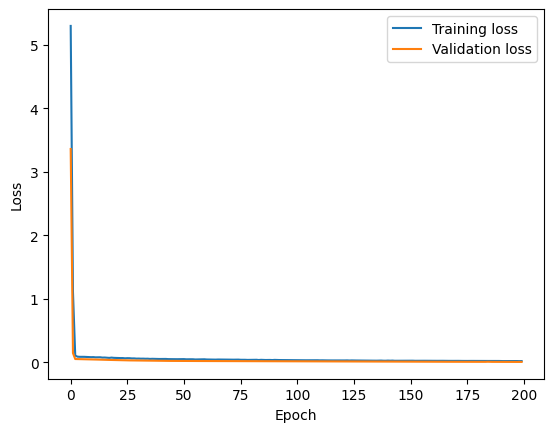

In [115]:
# График лосса

train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots()
ax.plot(train_loss, label='Training loss')
ax.plot(val_loss, label='Validation loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

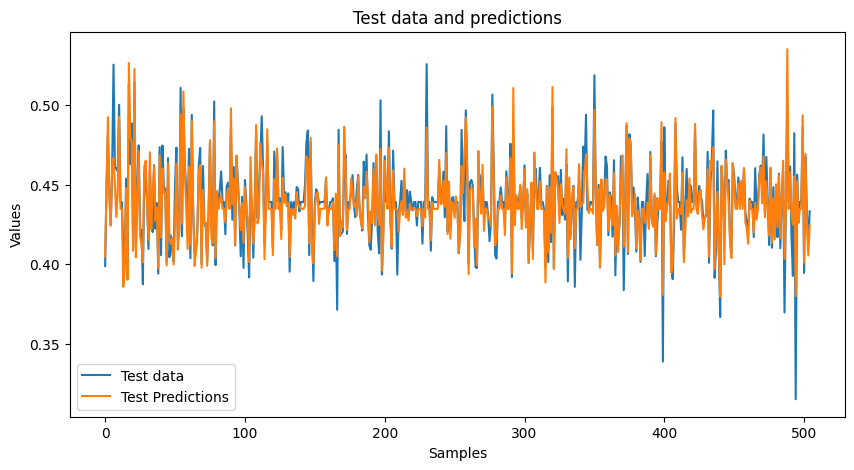

In [116]:
# Построение графика тестовой выборки и прогнозов

plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Test data')
plt.plot(y_pred, label='Test Predictions')
plt.title('Test data and predictions')
plt.xlabel('Samples')
plt.ylabel('Values') 
plt.legend()
plt.show()

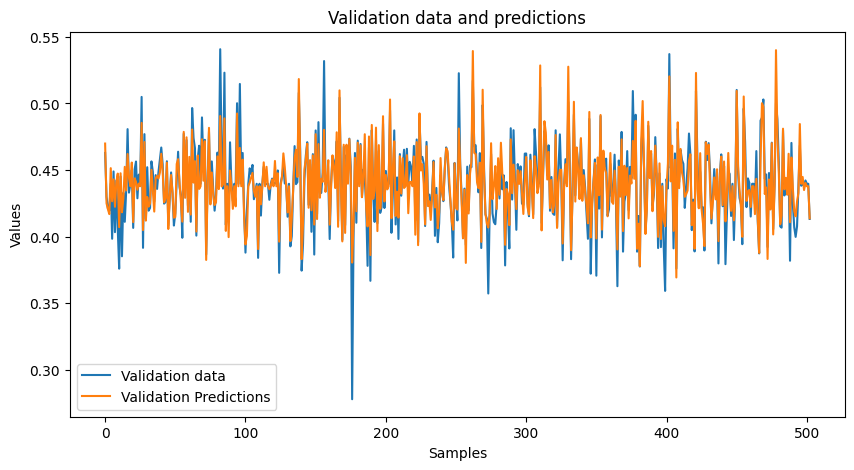

In [117]:
# Построение графика val выборки и прогнозов

plt.figure(figsize=(10, 5))
plt.plot(y_val, label='Validation data')
plt.plot(val_pred, label='Validation Predictions')
plt.title('Validation data and predictions')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()
plt.show()

In [118]:
# Вычисление квантильных ошибок
quan = []
for q in np.arange(0, 1.1, 0.1):
    quantile_error = np.abs(np.quantile(y_test, q) - np.quantile(y_pred, q))
    quan.append(quantile_error)
    print(f'Ошибка для квантиля {q.round(2)}: {quantile_error.round(3)}')

Ошибка для квантиля 0.0: 0.064
Ошибка для квантиля 0.1: 0.003
Ошибка для квантиля 0.2: 0.002
Ошибка для квантиля 0.3: 0.001
Ошибка для квантиля 0.4: 0.003
Ошибка для квантиля 0.5: 0.004
Ошибка для квантиля 0.6: 0.003
Ошибка для квантиля 0.7: 0.004
Ошибка для квантиля 0.8: 0.005
Ошибка для квантиля 0.9: 0.004
Ошибка для квантиля 1.0: 0.009


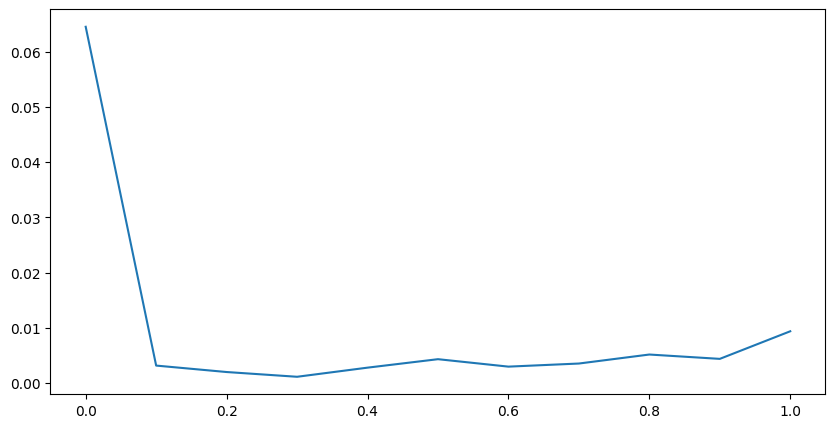

In [119]:
# График квантильной ошибки
quan_df = pd.DataFrame(quan, columns=['quantile error'])

index = np.arange(0, len(quan_df)*0.1, 0.1)
quan_df.set_index(index, inplace=True)

plt.figure(figsize=(10, 5))
plt.plot(quan_df)
plt.show()

In [6]:
# keras.losses.log_cosh

n_units = 512
dropout_rate = 0.4
activation = 'tanh'

model = Sequential()

model.add(LSTM(
    n_units, 
    activation=activation, 
    return_sequences=True,
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(Dropout(dropout_rate))

model.add(LSTM(
    n_units,
    activation=activation, 
    return_sequences=True
))
model.add(Dropout(dropout_rate))

model.add(LSTM(
    n_units, 
    activation=activation
))
model.add(Dropout(dropout_rate))

model.add(Dense(1))
model.add(Activation('linear'))

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=keras.losses.log_cosh) # keras.losses.log_cosh

history = model.fit(X_train,
                    y_train,
                    epochs=200,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    shuffle=False,
                    callbacks=[early_stopping])

# Предсказание значений на валидационной выборке
val_pred = model.predict(X_val)
print(f'MSE val: {mean_squared_error(y_val, val_pred):.4f}')
print(f'MAE val: {mean_absolute_error(y_val, val_pred):.4f}')
print(f'R2 val: {r2_score(y_val, val_pred):.4f}')
print(f'MAPE val: {mean_absolute_percentage_error(y_val, val_pred):.4f}')

# Предсказание значений на тестовой выборке
y_pred = model.predict(X_test)
print(f'MSE test: {mean_squared_error(y_test, y_pred):.4f}')
print(f'MAE test: {mean_absolute_error(y_test, y_pred):.4f}')
print(f'R2 test: {r2_score(y_test, y_pred):.4f}')
print(f'MAPE test: {mean_absolute_percentage_error(y_test, y_pred):.4f}')

Epoch 1/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0873 - val_loss: 0.0545
Epoch 2/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0349 - val_loss: 0.0018
Epoch 3/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0020 - val_loss: 6.7408e-04
Epoch 4/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0013 - val_loss: 6.6666e-04
Epoch 5/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0012 - val_loss: 6.4596e-04
Epoch 6/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0012 - val_loss: 6.3445e-04
Epoch 7/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0012 - val_loss: 6.2687e-04
Epoch 8/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0012 - val_loss: 6.2121e-04
Epoch 9/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0012 - val_loss: 6.1094e-04
Epoch 10/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0012 - val_loss: 6.0667e-04
Epoch 11/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0011 - val_loss: 6.0441e-04
Epoch 12/200
37/